<a href="https://colab.research.google.com/github/merazAfridi/PlayerVisionSegmentationGradCAM/blob/main/Football_Player_Segmentation_gradCam_Unet_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

gazimerazmehedi_football_players_train_test_path = kagglehub.dataset_download('gazimerazmehedi/football-players-train-test')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/football-players-train-test/data/Trainset/images/208.jpg
/kaggle/input/football-players-train-test/data/Trainset/images/473.jpg
/kaggle/input/football-players-train-test/data/Trainset/images/333.jpg
/kaggle/input/football-players-train-test/data/Trainset/images/45.jpg
/kaggle/input/football-players-train-test/data/Trainset/images/369.jpg
/kaggle/input/football-players-train-test/data/Trainset/images/56.jpg
/kaggle/input/football-players-train-test/data/Trainset/images/89.jpg
/kaggle/input/football-players-train-test/data/Trainset/images/20.jpg
/kaggle/input/football-players-train-test/data/Trainset/images/275.jpg
/kaggle/input/football-players-train-test/data/Trainset/images/212.jpg
/kaggle/input/football-players-train-test/data/Trainset/images/239.jpg
/kaggle/input/football-players-train-test/data/Trainset/images/58.jpg
/kaggle/input/football-players-train-test/data/Trainset/images/150.jpg
/kaggle/input/football-players-train-test/data/Trainset/images/6.jpg
/kaggle/input

In [ ]:
!pip install albumentations==1.2.1

In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
# Imports
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [ ]:

#Paths

train_image_dir = r'/kaggle/input/football-players-train-test/data/Trainset/images'
train_mask_dir  = r'/kaggle/input/football-players-train-test/data/Trainset/masks'
test_image_dir  = r'/kaggle/input/football-players-train-test/data/Testset/images'
test_mask_dir   = r'/kaggle/input/football-players-train-test/data/Testset/masks'


In [ ]:

#Create Custom Dataset

class FootballDataset(Dataset):
    def __init__(self, image_dir, mask_dir, joint_transform=None):
        """
        Args:
            image_dir (str): Directory with images.
            mask_dir (str): Directory with masks.
            joint_transform (callable, optional): Augmentation/Preprocessing to apply jointly.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = sorted(os.listdir(image_dir))
        self.mask_names  = sorted(os.listdir(mask_dir))
        self.joint_transform = joint_transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        # Load image,mask with PIL
        image_path = os.path.join(self.image_dir, self.image_names[idx])
        mask_path  = os.path.join(self.mask_dir, self.mask_names[idx])
        image = Image.open(image_path).convert("RGB")
        mask  = Image.open(mask_path).convert("L")  #grayscale mask

        #if joint transform provided, convert to NumPy array
        if self.joint_transform is not None:
            image_np = np.array(image)
            mask_np  = np.array(mask)
            augmented = self.joint_transform(image=image_np, mask=mask_np)
            image = augmented["image"]
            mask  = augmented["mask"]
            #ensurng mask has a channel dimension (1, H, W)
            if mask.ndim == 2:
                mask = mask.unsqueeze(0)
            #convert mask to float also scale to [0, 1]
            mask = mask.float() / 255.0
        return image, mask


In [ ]:

#Augmentations / Preprocessing Transforms

#Training set resize to 512x512
train_joint_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})

# Validation set,only resize and normalize(no random aug)
val_joint_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})

#test set same transform as validation
test_joint_transform = val_joint_transform


#create Dataset Instances & Split

#create full dataset for the training folder using the training transforms
full_dataset = FootballDataset(train_image_dir, train_mask_dir, joint_transform=train_joint_transform)

#Split into 90% train, 10% validation
total_samples = len(full_dataset)
split_index = int(0.9 * total_samples)
indices = list(range(total_samples))
train_indices = indices[:split_index]
val_indices   = indices[split_index:]

# For val creating separate dataset with val transform
full_dataset_val = FootballDataset(train_image_dir, train_mask_dir, joint_transform=val_joint_transform)

#create subset objects for train and val
train_subset = Subset(full_dataset, train_indices)
val_subset   = Subset(full_dataset_val, val_indices)

#DataLoaders
train_loader = DataLoader(train_subset, batch_size=4, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_subset, batch_size=4, shuffle=False, num_workers=2)

#create test dataset & loader
test_dataset = FootballDataset(test_image_dir, test_mask_dir, joint_transform=test_joint_transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)


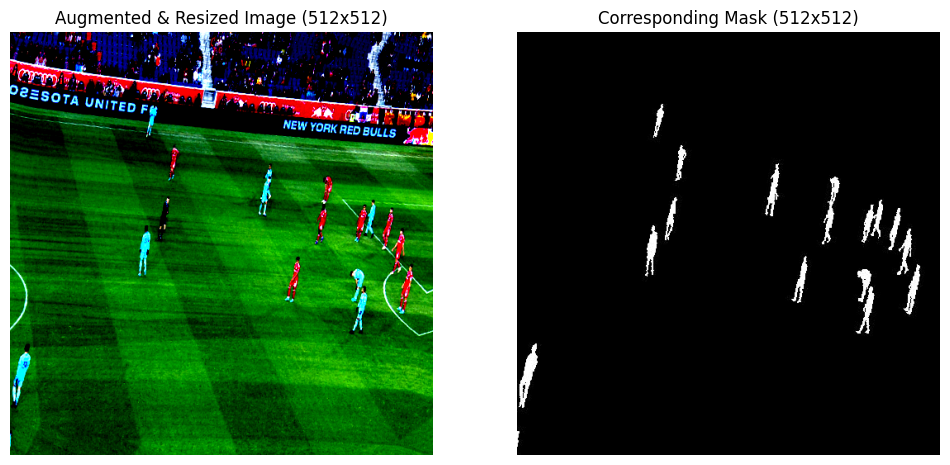

In [ ]:

#Visualize training Set

sample_image, sample_mask = full_dataset[0]
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(np.transpose(sample_image.cpu().numpy(), (1, 2, 0)))
plt.title("Augmented & Resized Image (512x512)")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(sample_mask.squeeze(), cmap='gray')
plt.title("Corresponding Mask (512x512)")
plt.axis('off')
plt.show()


In [ ]:

#evaluation Metrics
def dice_coef(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def jaccard_index(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return jaccard.mean()

def pixel_accuracy(pred, target):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    correct = (pred == target).float()
    return correct.sum() / correct.numel()

In [ ]:

#Model = UNet with ResNet50 Encoder

model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,                     #RGB images
    classes=1,                         # binary seg output
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Loss, Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
import os
import time
import torch

#directory to save model
checkpoint_dir = '/kaggle/working/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

num_epochs = 50
total_training_time = 0.0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_dices = []
val_dices = []
train_jaccards = []
val_jaccards = []

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    #train
    model.train()
    train_loss = 0.0
    train_dice = 0.0
    train_jaccard = 0.0
    train_acc = 0.0
    n_train_batches = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)  #shape= [B, 1, 512, 512] with values in [0,1]

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice_coef(outputs, masks).item()
        train_jaccard += jaccard_index(outputs, masks).item()
        train_acc += pixel_accuracy(outputs, masks).item()
        n_train_batches += 1

    train_loss /= n_train_batches
    train_dice /= n_train_batches
    train_jaccard /= n_train_batches
    train_acc /= n_train_batches

    #Val
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    val_jaccard = 0.0
    val_acc = 0.0
    n_val_batches = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_dice += dice_coef(outputs, masks).item()
            val_jaccard += jaccard_index(outputs, masks).item()
            val_acc += pixel_accuracy(outputs, masks).item()
            n_val_batches += 1

    val_loss /= n_val_batches
    val_dice /= n_val_batches
    val_jaccard /= n_val_batches
    val_acc /= n_val_batches

    epoch_time = time.time() - epoch_start_time
    total_training_time += epoch_time

    #append metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_dices.append(train_dice)
    val_dices.append(val_dice)
    train_jaccards.append(train_jaccard)
    val_jaccards.append(val_jaccard)


    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Dice: {train_dice:.4f}, Train Jaccard: {train_jaccard:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Dice: {val_dice:.4f}, Val Jaccard: {val_jaccard:.4f} | "
          f"Time: {epoch_time:.2f}s")

#save model
checkpoint_path = os.path.join(checkpoint_dir, 'Unet_ResNet50.pth')
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss,
    'train_dice': train_dice,
    'val_dice': val_dice,
    'train_jaccard': train_jaccard,
    'val_jaccard': val_jaccard,
    'train_acc': train_acc,
    'val_acc': val_acc
}, checkpoint_path)

print(f"Final model checkpoint saved at {checkpoint_path}")
print(f"Total Training Time: {total_training_time:.2f}s")


Epoch [1/50] - Train Loss: 0.3882, Train Acc: 0.9072, Train Dice: 0.4946, Train Jaccard: 0.3601 | Val Loss: 0.2641, Val Acc: 0.9731, Val Dice: 0.7157, Val Jaccard: 0.5610 | Time: 38.73s
Epoch [2/50] - Train Loss: 0.2087, Train Acc: 0.9716, Train Dice: 0.7640, Train Jaccard: 0.6199 | Val Loss: 0.1696, Val Acc: 0.9755, Val Dice: 0.7682, Val Jaccard: 0.6254 | Time: 39.54s
Epoch [3/50] - Train Loss: 0.1486, Train Acc: 0.9727, Train Dice: 0.8078, Train Jaccard: 0.6784 | Val Loss: 0.1273, Val Acc: 0.9763, Val Dice: 0.8146, Val Jaccard: 0.6884 | Time: 42.58s
Epoch [4/50] - Train Loss: 0.1135, Train Acc: 0.9733, Train Dice: 0.8348, Train Jaccard: 0.7171 | Val Loss: 0.0990, Val Acc: 0.9768, Val Dice: 0.8416, Val Jaccard: 0.7273 | Time: 44.77s
Epoch [5/50] - Train Loss: 0.0899, Train Acc: 0.9737, Train Dice: 0.8527, Train Jaccard: 0.7437 | Val Loss: 0.0782, Val Acc: 0.9771, Val Dice: 0.8609, Val Jaccard: 0.7562 | Time: 44.16s
Epoch [6/50] - Train Loss: 0.0712, Train Acc: 0.9739, Train Dice: 0.86

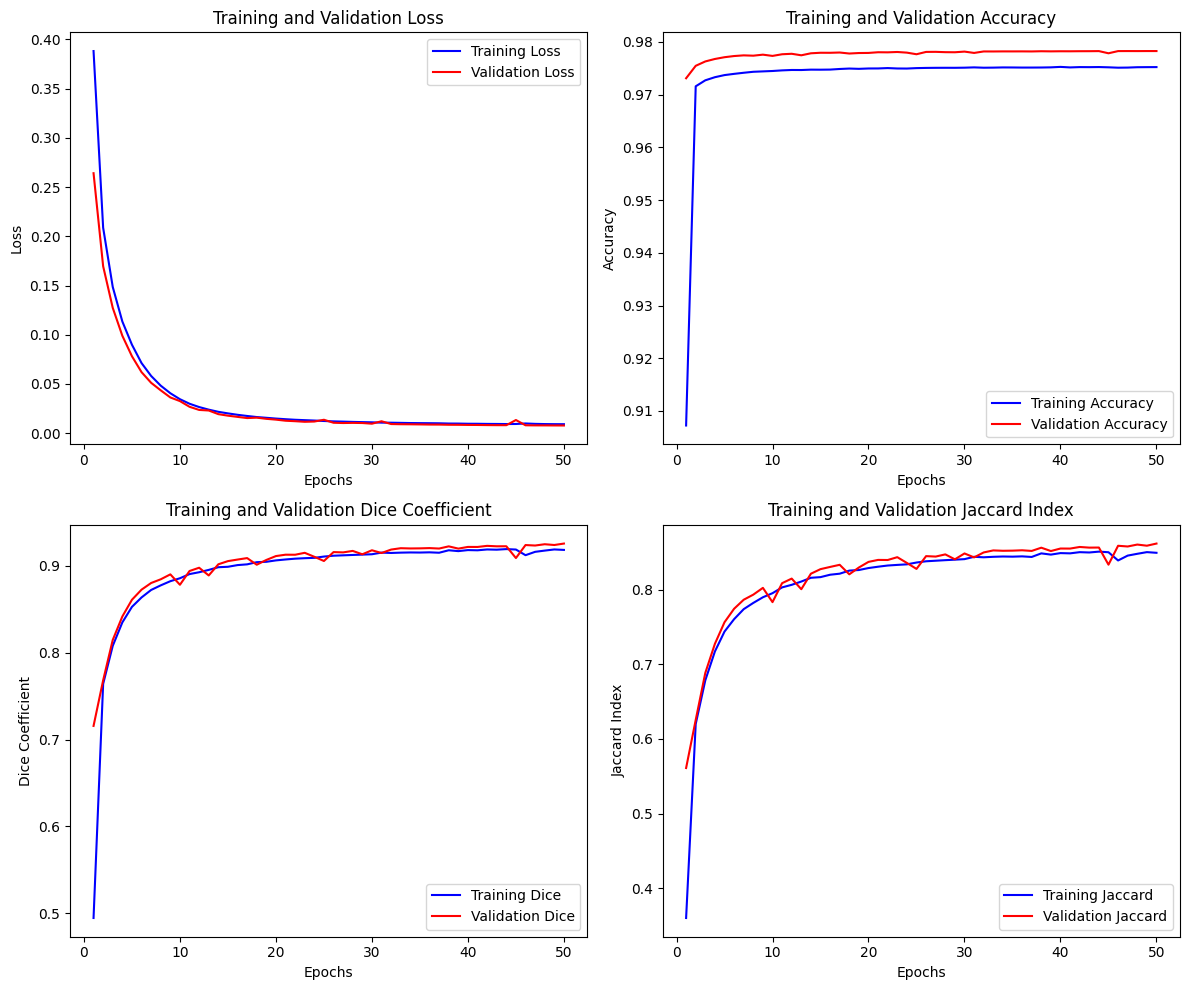

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 10))

#loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#dice coefficient
plt.subplot(2, 2, 3)
plt.plot(epochs, train_dices, 'b', label='Training Dice')
plt.plot(epochs, val_dices, 'r', label='Validation Dice')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

#jaccard index
plt.subplot(2, 2, 4)
plt.plot(epochs, train_jaccards, 'b', label='Training Jaccard')
plt.plot(epochs, val_jaccards, 'r', label='Validation Jaccard')
plt.title('Training and Validation Jaccard Index')
plt.xlabel('Epochs')
plt.ylabel('Jaccard Index')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#evaluate on Test Set

model.eval()
test_loss = 0.0
test_acc = 0.0
test_dice = 0.0
test_jaccard = 0.0
n_test_batches = 0

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        test_loss += loss.item()
        test_dice += dice_coef(outputs, masks).item()
        test_jaccard += jaccard_index(outputs, masks).item()
        test_acc += pixel_accuracy(outputs, masks).item()
        n_test_batches += 1

test_loss /= n_test_batches
test_dice /= n_test_batches
test_jaccard /= n_test_batches
test_acc /= n_test_batches

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Dice: {test_dice:.4f}")
print(f"Test Jaccard: {test_jaccard:.4f}")


Test Loss: 0.0084
Test Accuracy: 0.9737
Test Dice: 0.9367
Test Jaccard: 0.8810


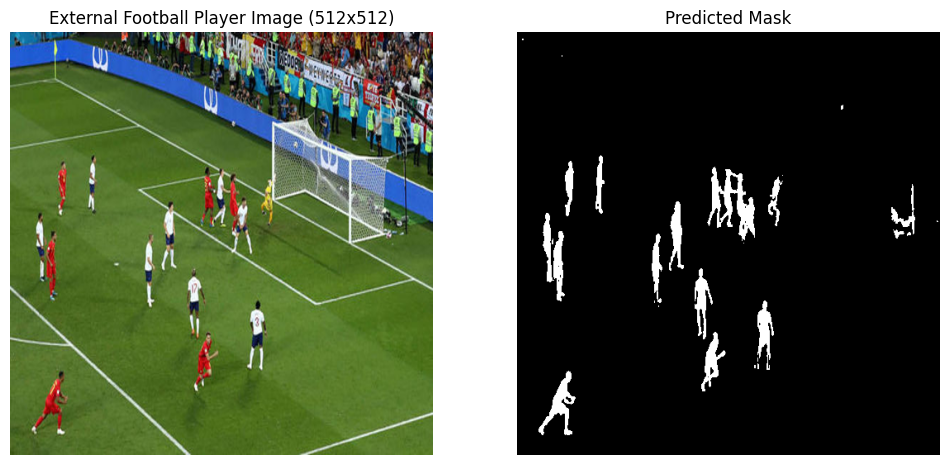

In [ ]:

#external image (Download, Resize, Predict)

image_url = "https://cdn.images.express.co.uk/img/dynamic/67/590x/England-vs-Colombia-time-983344.jpg"
response = requests.get(image_url)
ext_image = Image.open(BytesIO(response.content)).convert("RGB")

ext_image_resized = ext_image.resize((512, 512))


#preprocess same as val
ext_image_np = np.array(ext_image_resized)
#for dummy mask, we can pass the same image- it won't use
processed = val_joint_transform(image=ext_image_np, mask=ext_image_np)
input_image = processed["image"].unsqueeze(0).to(device)  #add batch dim


model.eval()
with torch.no_grad():
    output = model(input_image)
    pred_mask = torch.sigmoid(output)
    pred_mask = (pred_mask > 0.5).float().cpu().squeeze()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(ext_image_resized)
plt.title("External Football Player Image (512x512)")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis('off')
plt.show()

In [ ]:
pip install grad-cam

Note: you may need to restart the kernel to use updated packages.


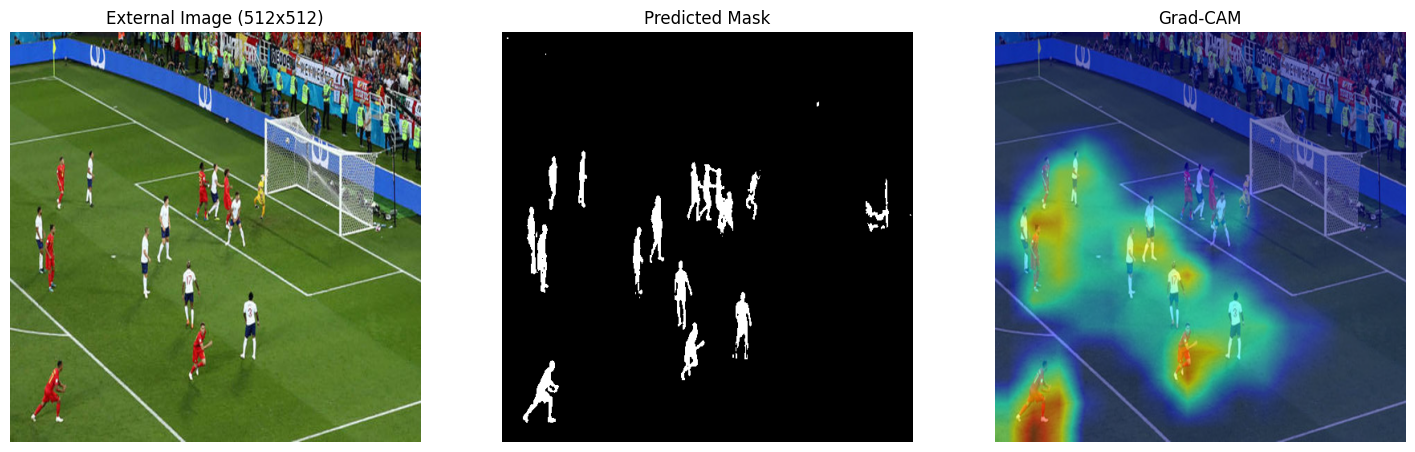

In [ ]:
#pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


#GradCAM

#external image as a NumPy array
#preprocess the external img using gradcam func
input_tensor_cam = preprocess_image(ext_image_np,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

#target layer
#for  U-Net with a ResNet50 encoder (from segmentation_models_pytorch), using the last block of layer4.
target_layer = model.encoder.layer4[-1]  #adjust if needed

#initialize GradCAM
cam = GradCAM(model=model, target_layers=[target_layer])


#since the output for single sample is likely shape (1, H, W),we simply take its mean
targets = [lambda output: output.mean()]

#gen Grad-CAM
grayscale_cam = cam(input_tensor=input_tensor_cam, targets=targets)[0]

visualization = show_cam_on_image(ext_image_np.astype(np.float32) / 255.0,
                                  grayscale_cam,
                                  use_rgb=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(ext_image_resized)
axes[0].set_title("External Image (512x512)")
axes[0].axis("off")


axes[1].imshow(pred_mask, cmap="gray")
axes[1].set_title("Predicted Mask")
axes[1].axis("off")


axes[2].imshow(visualization)
axes[2].set_title("Grad-CAM")
axes[2].axis("off")

plt.show()


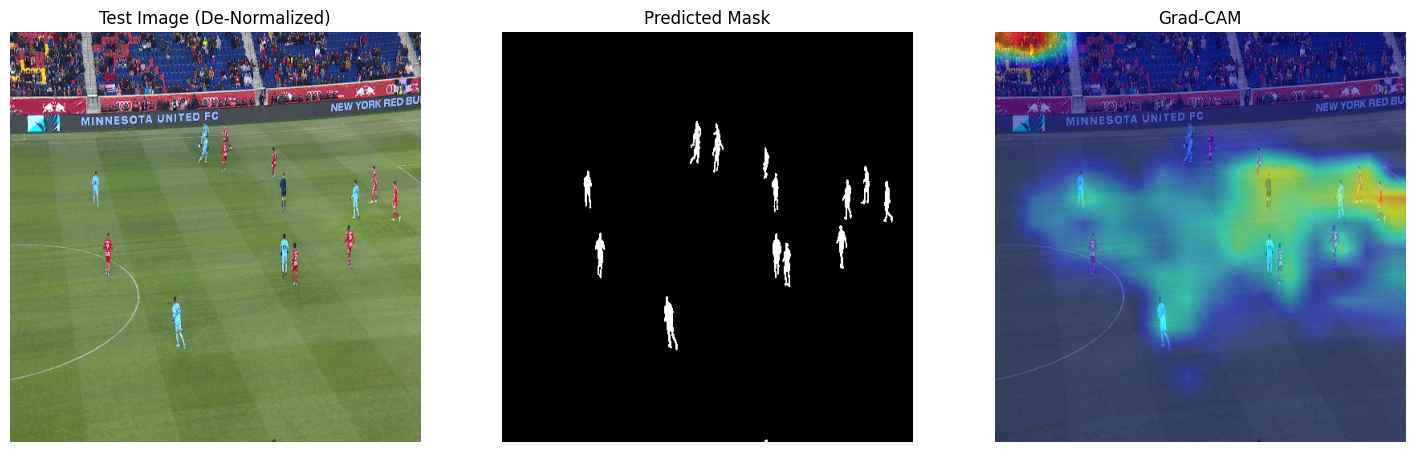

In [ ]:
#gradCAM Analysis on Test Sample
#get 1 batch from test_loader, pick the 1st sample
test_iter = iter(test_loader)
test_images, test_masks = next(test_iter)

input_image_test = test_images[0:1].to(device)

#denormalize test img for visualization
#(Normalization was applied using mean=[0.485, 0.456, 0.406] , std=[0.229, 0.224, 0.225])
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
denorm_img = input_image_test[0].cpu().clone()
for t, m, s in zip(denorm_img, mean, std):
    t.mul_(s).add_(m)
denorm_img_np = denorm_img.clamp(0, 1).permute(1, 2, 0).numpy()  # shape: (H, W, C)


target_layer = model.encoder.layer4[-1] #Adjust which layer


from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
cam = GradCAM(model=model, target_layers=[target_layer])

targets = [lambda output: output.mean()]

grayscale_cam = cam(input_tensor=input_image_test, targets=targets)[0]


visualization = show_cam_on_image(denorm_img_np.astype(np.float32),
                                  grayscale_cam,
                                  use_rgb=True)


model.eval()
with torch.no_grad():
    output_test = model(input_image_test)
    pred_mask_test = torch.sigmoid(output_test)
    pred_mask_test = (pred_mask_test > 0.5).float().cpu().squeeze()


import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(denorm_img_np)
axes[0].set_title("Test Image (De-Normalized)")
axes[0].axis("off")

axes[1].imshow(pred_mask_test, cmap="gray")
axes[1].set_title("Predicted Mask")
axes[1].axis("off")

axes[2].imshow(visualization)
axes[2].set_title("Grad-CAM")
axes[2].axis("off")

plt.show()
